# Imports 

In [1]:
%matplotlib inline
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pickle
import sklearn.decomposition
import sklearn.cluster
import matplotlib.cm
import importlib
from matplotlib import animation
from IPython.display import HTML

# Data loading
## Spike extraction

In [2]:
data_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont'
video_root = '/home/mano/Documents/Profesional Projects/Raster_tuto/spont/cam/'

dbs = {'mouse_name': 'TX60', 'date': '2020_10_20', 'exp': '2', 'cam': ['0', '1']}

In [3]:
dat = np.load(os.path.join(data_root, 'spont_2cam_%s_%s.npz'%
                  (dbs['mouse_name'], dbs['date'])))

spks = dat['spks'].astype(np.float32)

Exploring the `npz` data structure:

In [4]:
dat.files

['spks', 'tcam', 'ypos', 'xpos', 'tneural', 'run']

In [5]:
spks.shape

(42568, 23185)

(neurons) x n_samples

## spike normalization

In [6]:
spks -= spks.mean(axis=1)[:,np.newaxis]
spks /= ((spks**2).mean(axis=1)**0.5)[:,np.newaxis]

# Rastermap fit

In [7]:
sys.path.insert(0, '/home/mano/Documents/Profesional Projects/RasterMap')
from rastermap import mapping

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
RM_model = mapping.Rastermap(smoothness=1, 
                           n_clusters=100, 
                           n_PCs=128, 
                           ts=0.9,
                           time_lag_window=0,
                           grid_upsample=10,
                           n_splits=0).fit(spks, normalize=False) # (we've already normalized)

n_PCs = 128 computed, time 28.61
landmarks computed and embedded, time 44.40
grid upsampled, time 47.51


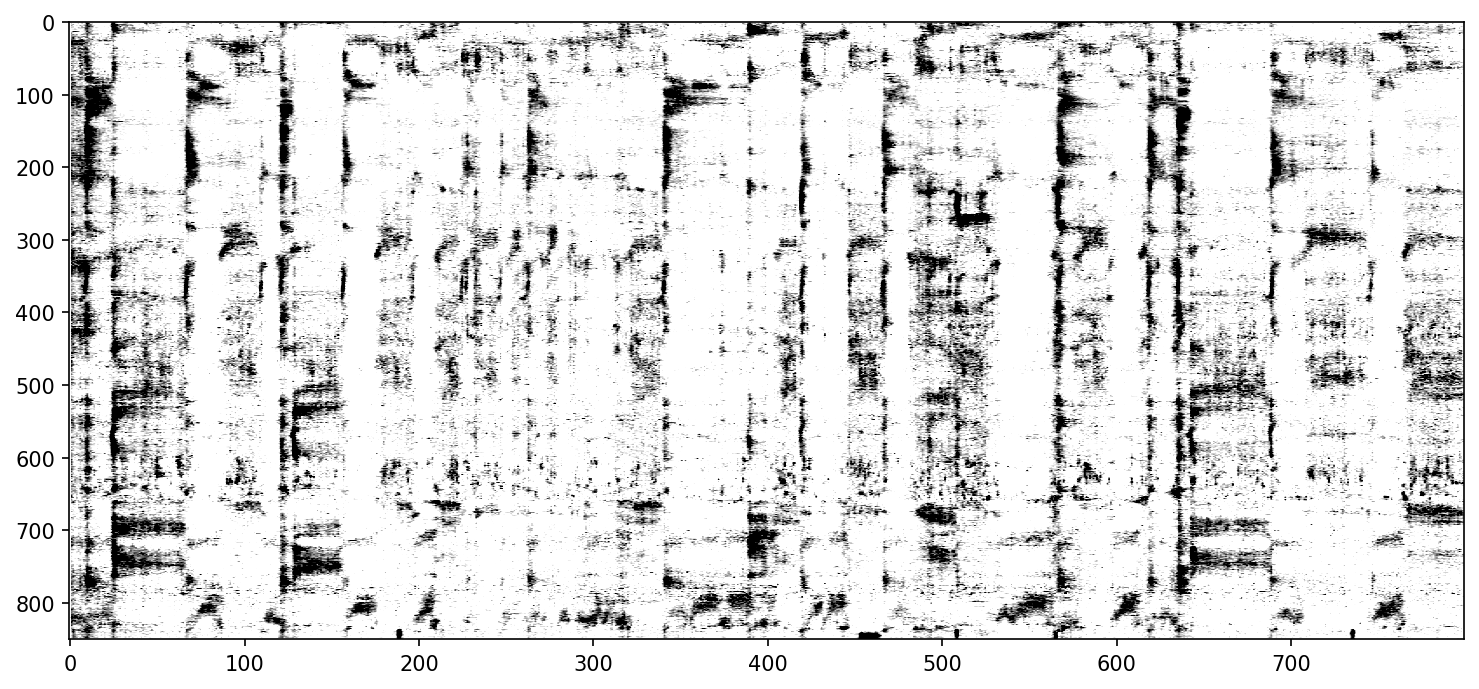

In [9]:
from scipy.stats import zscore
plt.figure(figsize=(12,12), dpi=150)
xmin=0
xmax=xmin+800
plt.subplot(2,1,1)
plt.imshow(zscore(RM_model.X_embedding[:,xmin:xmax], axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

In [10]:
RM_model.X_embedding.shape

(851, 23185)

In [28]:
np.squeeze(RM_model.embedding).shape

(42568,)

In [29]:
np.unique(np.squeeze(RM_model.embedding)).shape

(998,)

In [31]:
RM_model.bin_size * 851

42550

super_neurons  x timepoints (its already binned in bins of 50 neurons)

## Needs work -v 

In [31]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [32]:
n_comps = 128 # chose to match rastermap output dimension 
pca_128 = PCA(n_components=n_comps).fit(spks)

*loadings* = linear combination of the original variables (aka timepoints in this case) from which the principal components (PCs) are constructed. `pca_128.components_`

In [33]:
U = spks@pca_128.components_.T
U.shape

(42568, 128)

### foor loop to try different number of clusters

* Just to test I took 100 clusters

In [176]:
clusters = [50,100,150,200,300,400]
labels = []
centroids = []
sse = []
sil_score = []
for ncluster in clusters:
    kmeans = KMeans(n_clusters=ncluster, n_init=1, random_state=0).fit(U)
    labels.append(kmeans.labels_)
    centroids.append(kmeans.cluster_centers_)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

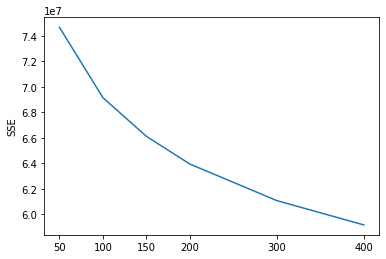

In [177]:
### This makes sense with more models fitted
sse = np.asarray(sse)
fig, ax1 = plt.subplots(1, 1, sharex=True)
clusters_arr = np.asarray(clusters)
ax1.plot(clusters_arr, sse)
ax1.set_xticks(clusters_arr)
ax1.set_ylabel("SSE")
###

# Just neurons sorted by cluster
## Todo: cluster rearrangement 

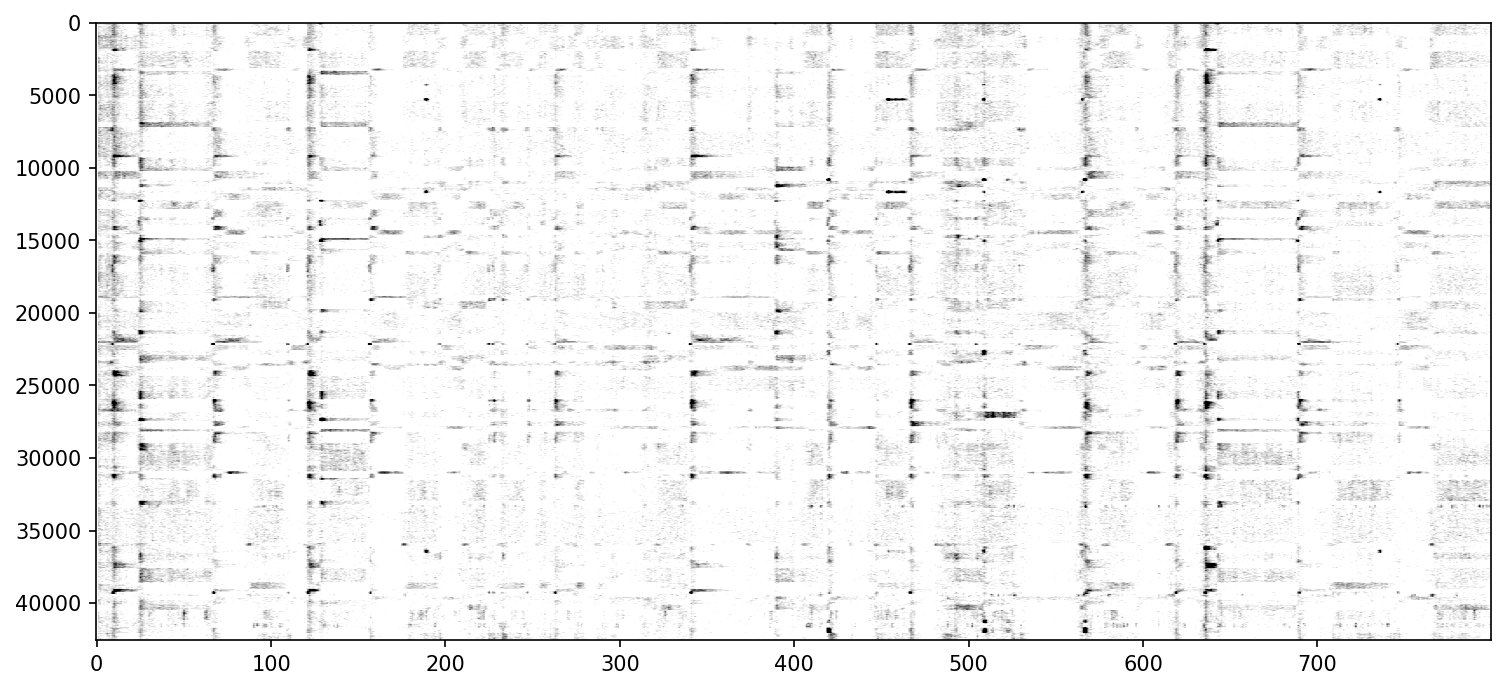

In [178]:
labels = np.asarray(labels[1]) #Getting the labels of the run with 100 clusters
centroids = np.asarray(centroids[1])
sort_idx=np.argsort(labels) 
pc_sort_knn=zscore(spks[sort_idx,xmin:xmax],axis=1)
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(pc_sort_knn, vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Putting similar clusters close each other (?)
I will try to put clusters together by simply doing an agglomerative clustering on the clusters_centers of the Kmeans algo

In [187]:
from sklearn.cluster import AgglomerativeClustering
Cluster_rearrange=AgglomerativeClustering(n_clusters=12).fit(centroids)

In [188]:
order = np.argsort(Cluster_rearrange.labels_)
spks_ordered = np.empty([])
for ord in order:
    sort_idx=np.where(labels==ord)[0]
    spks_ordered = np.append(spks_ordered,spks[sort_idx,xmin:xmax])
spks_ordered = spks_ordered[1:].reshape(-1,800)

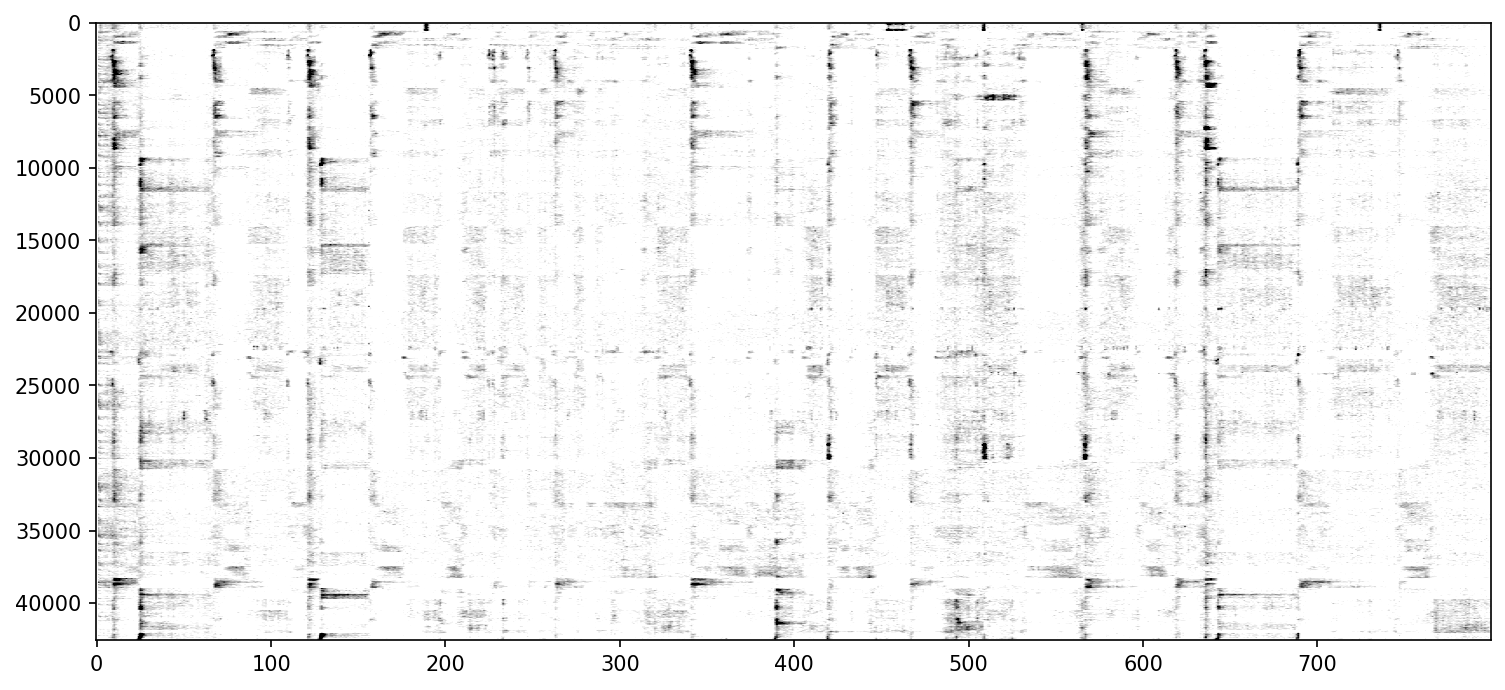

In [189]:
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(zscore(spks_ordered,axis=1), vmin=0, vmax=2, cmap='gray_r', aspect='auto')

# Leinden Algo 

## Louvian - Leiden algo

## Louvian

>The Louvain algorithm searches for high-quality clusters by moving individual nodes—for instance individual articles in a citation network—from one cluster to another in such a way that the quality of the clusters is improved as much as possible. When clusters cannot be improved further by moving individual nodes, the Louvain algorithm does something ingenious: it aggregates the network, so that each cluster in the original network becomes a node in the aggregated network. In the aggregated network, the algorithm then starts to move individual nodes from one cluster to another.

--
## BIG FLAW: 

*Sometimes, a node functions as a middle man or a bridge for the rest of its cluster. Without that crucial node, the cluster would not be connected anymore. Since the Louvain algorithm keeps moving nodes from one cluster to another, at some point it may move the crucial node to a different cluster, thereby breaking the connectivity of the original cluster*

## Leiden

Leiden algorithm is able to split clusters instead of only merging them, as is done by the Louvain algorithm. By splitting clusters in a specific way, the Leiden algorithm guarantees that clusters are well-connected. Moreover, the algorithm guarantees more than this: if we run the algorithm repeatedly, we eventually obtain clusters that are subset optimal.

*This means that it is impossible to improve the quality of the clusters by moving one or more nodes from one cluster to another*

Rather than continuously checking for all nodes in a network whether they can be moved to a different cluster, as is done in the Louvain algorithm, the Leiden algorithm performs this check only for so-called unstable nodes. As a result, the Leiden algorithm does not only find higher quality clusters than the Louvain algorithm, it also does so in much less time.

In [194]:
import scanpy as sc
adata = sc.AnnData(spks)
sc.tl.pca(adata, n_comps=128)
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=128) #matching previous hyperparameters
sc.tl.leiden(adata, resolution=1)
leiden_labels = adata.obs['leiden'].astype(int)

In [198]:
print(f'number of clusters by leiden algo: { len(np.unique(leiden_labels))}')

number of clusters by leiden algo: 13


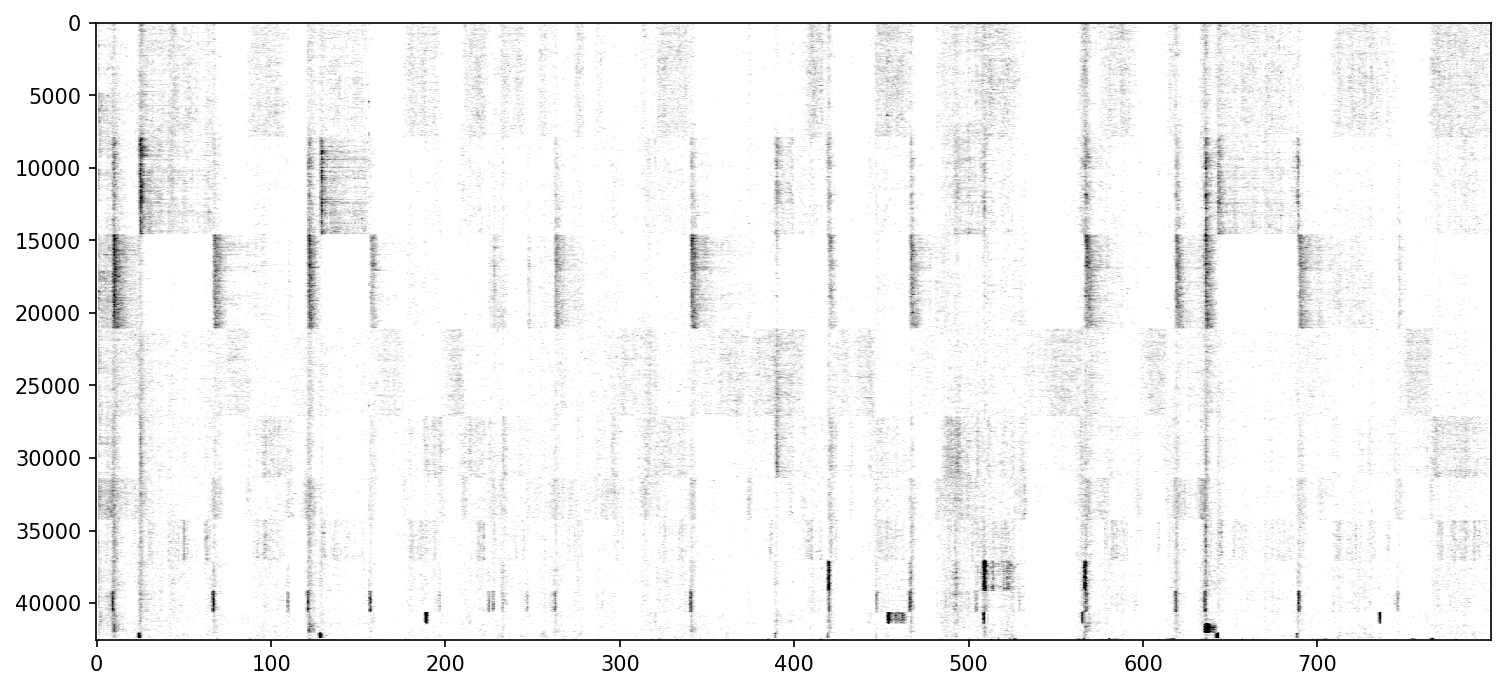

In [195]:
sort_idx=np.argsort(leiden_labels) 
pc_sort_leid=zscore(spks[sort_idx,xmin:xmax],axis=1)
plt.figure(figsize=(12,12), dpi=150)
plt.subplot(2,1,1)
plt.imshow(pc_sort_leid, vmin=0, vmax=2, cmap='gray_r', aspect='auto')